# Load data

In [1]:
import pickle

import numpy as np
import yaml
from nuance import Nuance
from nuance.kernels import rotation
from nuance.utils import periodic_transit
from nuance.star import Star

# load data
tic = "306331621"
lc_file = f"../data/{tic}/cleaned_lc.fluxes"
gp_file = f"../data/{tic}/gp.yaml"
data = pickle.load(open(lc_file, "rb"))
gp_params = yaml.full_load(open(gp_file, "r"))

np.random.seed(271)

star = Star(
    data["star_radius"], data["star_mass"], data["star_amplitude"], data["star_period"]
)

# inject
true_period = 2
radius = 3.5

duration = star.transit_duration(true_period)
depth = star.transit_depth(radius)
true_t0 = np.random.rand() * true_period

transit = depth * periodic_transit(data["time"], true_t0, duration, P=true_period)
injected_flux = data["flux"] + transit
data["flux"] = injected_flux

/Users/lgrcia/code/dev/nuance/nuance/nuance.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
dt = np.median(np.diff(data["time"]))
N = len(data["time"])
sigma = np.median(data["error"])
print(f"SNR: {star.snr(true_period, radius, N, sigma):.2f}")


SNR: 51.44


In [3]:
lc_file = f"/Users/lgrcia/code/studies/paper-nuance/workflows/real_injection_recovery/data/{tic}/injected/303.fluxes"
data = pickle.load(open(lc_file, "rb"))
true_t0 = data["transit_t0"]
true_period = data["planet_period"]
duration = data["transit_duration"]


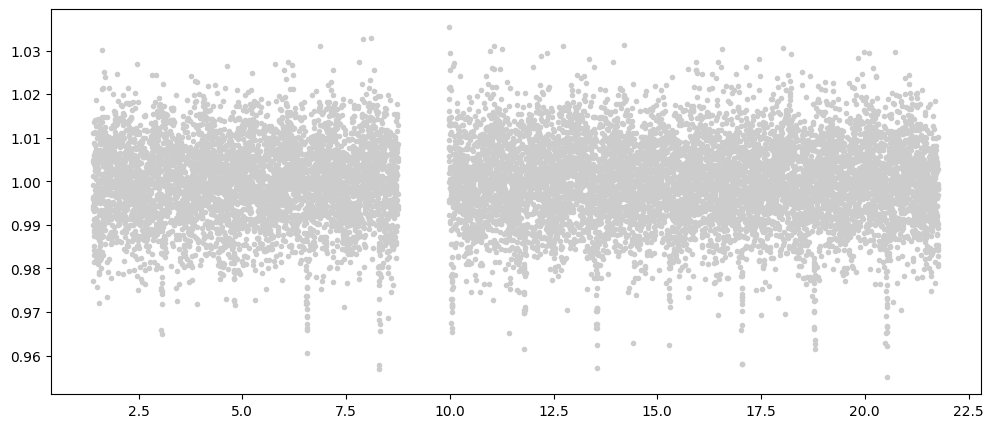

In [4]:
import matplotlib.pyplot as plt

plt.figure(None, (12, 5))
plt.plot(data["time"], data["flux"], ".", c="0.8")
# plt.plot(data["time"], transit+1., c="k")
# plt.xlim(0, 3)

# Search
## Nuance

In [5]:
# nuance
build_gp, _ = rotation(data["star_period"])
gp = build_gp(gp_params, data["time"])

nu = Nuance(data["time"], data["flux"], gp=gp)

nu.linear_search(data["time"][1000:], np.array([0.01, duration]))


100%|██████████| 12600/12600 [00:14<00:00, 890.29it/s]


In [6]:
from nuance.utils import clean_periods

periods = np.linspace(0.1, 11.0, 10000)
periods = clean_periods(periods, data["star_period"])
search = nu.periodic_search(periods)


100%|██████████| 9602/9602 [00:16<00:00, 580.56it/s]


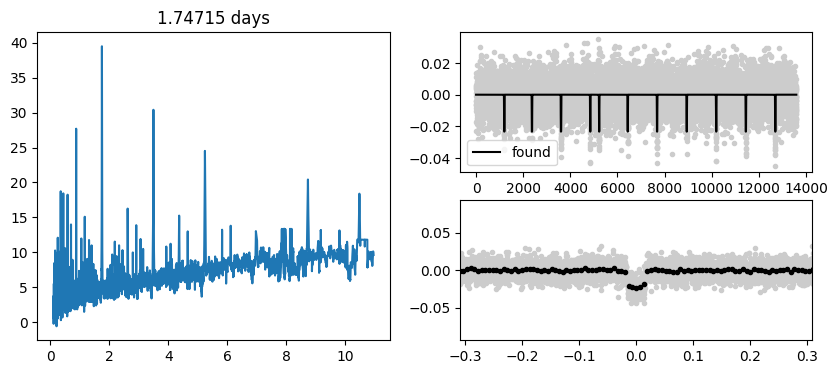

In [7]:
from nuance.utils import plot_search

plt.figure(None, (10, 4))
plot_search(nu, search)


In [8]:
def right_candidate(t0, period, true_t0, true_period, verbose=False):
    t0_check = (
        np.abs((t0 - true_t0 + 0.5 * true_period) % true_period - 0.5 * true_period)
        % period
        < 0.01
    )
    period_check = np.abs(period - true_period) < 0.1
    period_check |= np.abs(2 * period - true_period) < 0.1
    period_check |= np.abs(period / 2 - true_period) < 0.1
    same = np.logical_and(t0_check, period_check)
    if verbose:
        if not same:
            if not t0_check:
                output = f"t0 differ: {t0:.2e} {true_t0:.2e}"
            if not period_check:
                output = f"period differ: {period:.2e} {true_period:.2e}"
        else:
            output = "match"
        return same, output
    else:
        return same


t0, _, period = search.best

right_candidate(t0, period, true_t0, true_period)


True

## TLS

In [13]:
import numpy as np
import sys

sys.path.append("../lib")
from tls import tls
from wotan import flatten

import pickle
import numpy as np
import yaml


def trend(time, flux, window_length):
    return (
        flatten(time, flux + 1000.0, window_length=window_length, return_trend=True)[1]
        - 1000.0
    )


def tls_search(time, flux, window_length, periods, verbose=False):
    flatten_trend = trend(time, flux, window_length)
    flatten_flux = flux - flatten_trend
    flatten_flux -= np.mean(flatten_flux)
    flatten_flux += 1.0

    model = tls(time, flatten_flux, verbose=verbose)
    results = model.power(
        periods,
        verbose=verbose,
        use_threads=10,
        show_progress_bar=verbose,
        durations=[0.01, duration],
    )

    return results["T0"], results["period"], results["power"]


true_t0, period, power = tls_search(
    data["time"], data["flux"], data["star_period"] / 4, periods, verbose=True
)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 2 durations
Searching 13594 data points, 9602 periods from 0.1 to 10.965 days
Using all 10 CPU threads


100%|██████████| 9602/9602 periods | 00:06<00:00


Searching for best T0 for period 1.74824 days


In [14]:
right_candidate(t0, period, true_t0, true_period)

True

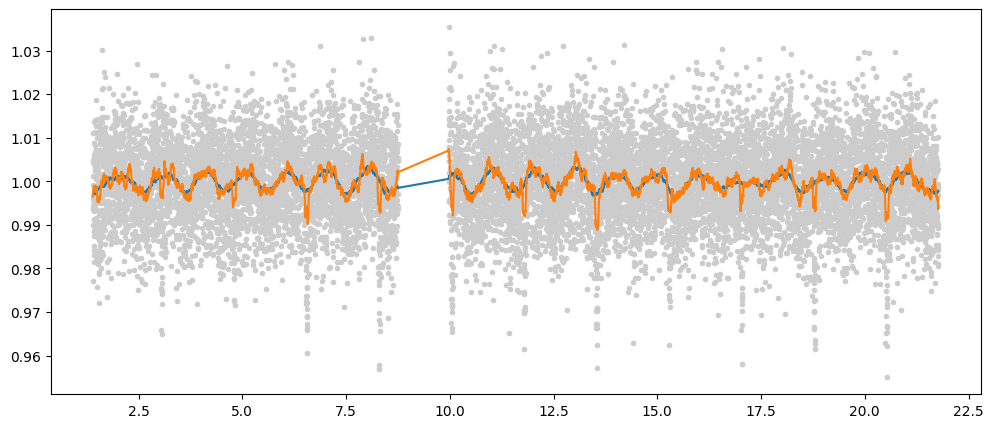

In [19]:
t = trend(data["time"], data["flux"], data["star_period"] / 4)

plt.figure(None, (12, 5))
plt.plot(data["time"], data["flux"], ".", c="0.8")
plt.plot(data["time"], trend(data["time"], data["flux"], data["star_period"] / 3))
plt.plot(data["time"], trend(data["time"], data["flux"], data["transit_duration"] * 3))

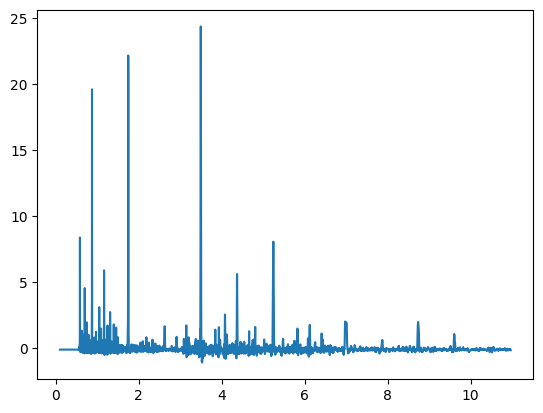

In [16]:
plt.plot(periods, power)
